In [1]:
using ControlSystems
using PyPlot
using LinearAlgebra

┌ Info: Precompiling ControlSystems [a6e380b2-a6ca-5380-bf3e-84a91bcd477e]
└ @ Base loading.jl:1278


In [2]:
# dynamics
h = 0.1   # time step
B = [0.5*h*h; h]
A = I + [0 1; 0 0]*h

nx= 2               # number of states
nu = 1              # number of controls
Tf = 10.0            # final time
N = Int(Tf/h)+1     # number of time steps
times = Array(range(0,Tf, step=h));

In [3]:
x0 = [2.0; 0.0]     # initial state
xs = [0.0; 0.0]     # target state

2-element Array{Float64,1}:
 0.0
 0.0

In [12]:
Q = Array(1.0 * I(nx))
Qn = Array(1.0 * I(nx))
R = 0.1

0.1

In [13]:
function get_J(xhist,uhist)
    cost = 0.5*(xhist[:,end])'*Qn*(xhist[:,end])
    for k = 1:(N-1)
        cost = cost + 0.5*(xhist[:,k])'*Q*(xhist[:,k]) + 0.5*uhist[:,k]'*R*uhist[:,k]
    end
    return cost
end

get_J (generic function with 1 method)

In [24]:
P = zeros(nx, nx, N)
K = zeros(nu, nx, N-1)
P[:,:,N] .= Qn

# Backward Ricatti Recursion
for i=(N-1):-1:1
    K[:,:,i] .= (R + B' * P[:,:,i+1] * B) \ (B' * P[:,:,i+1] * A)
    P[:,:,i] .= Q + A' * P[:,:,i+1] * A - A' * P[:,:,i+1] * B * K[:,:,i]
end

# Forwward Simulation
xhist = zeros(nx, N)
uhist = zeros(nu, N-1)
@show xhist[:, 1] = x0
for k=1:1:(N-1)
    uhist[:,k] .= -K[:,:,k] * xhist[:,k]
    xhist[:,k+1] .= A * xhist[:,k] + B * uhist[k]
end

xhist[:, 1] = x0 = [2.0, 0.0]


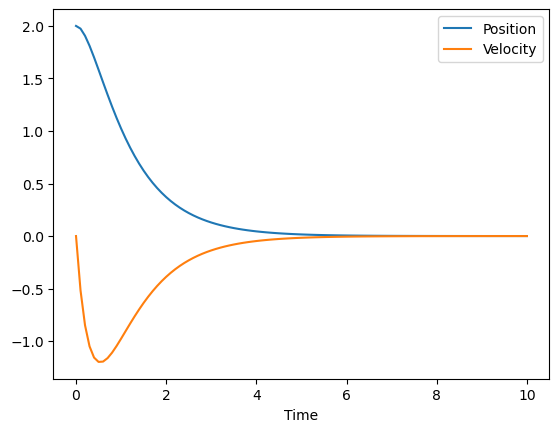

PyObject <matplotlib.legend.Legend object at 0x00000000400C43D0>

In [26]:
plot(times, xhist[1,:],label = "Position")
plot(times, xhist[2,:],label = "Velocity")
xlabel("Time")
legend()

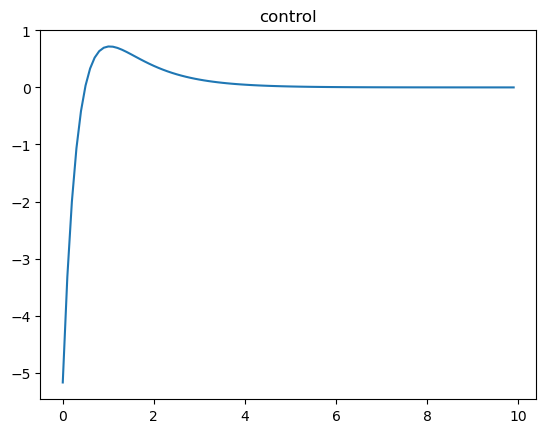

PyObject Text(0.5, 1.0, 'control')

In [31]:
plot(times[1:N-1], uhist[1,:])
title("control")

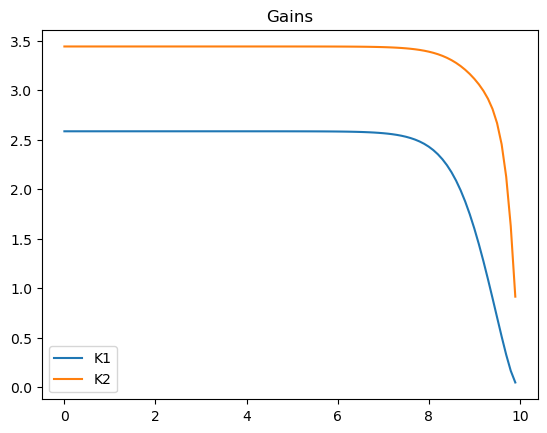

PyObject <matplotlib.legend.Legend object at 0x0000000040450C70>

In [38]:
plot(times[1:N-1], K[1,1,:], label = "K1")
plot(times[1:N-1], K[1,2,:], label = "K2")
title("Gains")
legend()

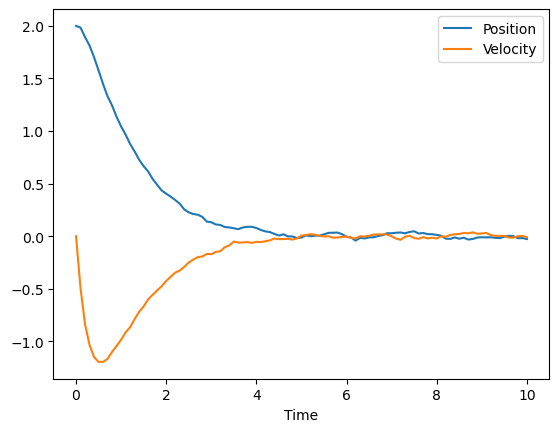

J = get_J(xhist, uhist) = 27.238883348476477


27.238883348476477

In [36]:
# run a simulation with state noise
xhist = zeros(nx, N)
uhist = zeros(nu, N-1)
xhist[:, 1] = x0
for k=1:1:(N-1)
    uhist[:,k] .= -K[:,:,k] * xhist[:,k]
    xhist[:,k+1] .= A * xhist[:,k] + B * uhist[k] + 0.01 * randn(nx)
end
plot(times, xhist[1,:],label = "Position")
plot(times, xhist[2,:],label = "Velocity")
xlabel("Time")
legend()
@show J = get_J(xhist, uhist)

In [39]:
# using ControlSystems.jl 
Kinf = ControlSystems.dlqr(A,B,Q,R)

1×2 Adjoint{Float64,Array{Float64,1}}:
 2.5857  3.44344

In [40]:
K[:,:,1] - Kinf

1×2 Array{Float64,2}:
 -6.72933e-9  -2.28765e-9

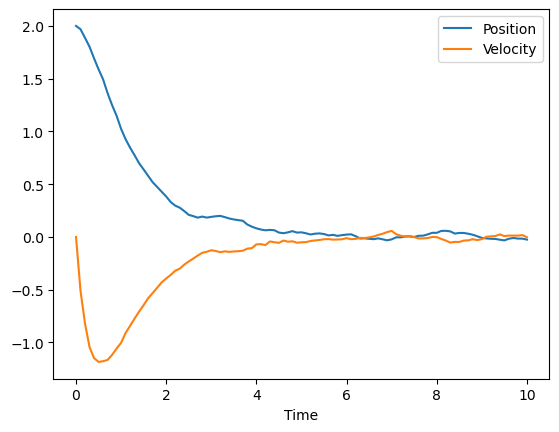

J = get_J(xhist, uhist) = 27.000744007755944


27.000744007755944

In [42]:
# For stablization, use constant Kinf
xhist = zeros(nx, N)
uhist = zeros(nu, N-1)
xhist[:, 1] = x0
for k=1:1:(N-1)
    uhist[:,k] .= -Kinf * xhist[:,k]
    xhist[:,k+1] .= A * xhist[:,k] + B * uhist[k] + 0.01 * randn(nx)
end
plot(times, xhist[1,:],label = "Position")
plot(times, xhist[2,:],label = "Velocity")
xlabel("Time")
legend()
@show J = get_J(xhist, uhist)